In [1]:
import numpy as np
np.random.seed(42)
import tensorflow.compat.v1 as tf
import keras as K
import pandas as pd
import os

os.environ['CUDA_VISIBLE_DEVICES']='0'
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import backend
# from numba import cuda
from keras.models import load_model
import time 
%matplotlib inline 

d:\other_all\application\python\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\other_all\application\python\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\other_all\application\python\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\other_all\application\python\lib\site-packages\tensorflow\python\framework\dtypes.

In [2]:
# import tensorflow as tf # tf.__version__ == 2.1.0, keras.__version__ == 2.3.1
# https://blog.csdn.net/u012388993/article/details/102573008
# import keras.backend.tensorflow_backend as ktf
# https://blog.csdn.net/zuoyouzouzou/article/details/104329286
import tensorflow.compat.v1 as tf
import tensorflow.compat.v1.keras.backend as ktf

# GPU 显存自动调用
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
ktf.set_session(session)

In [3]:
train_path = r'flowers_google'
labels_path = "flowers_label.csv"
ids_path = "flowers_idx.csv"

In [4]:
def PrepareAnnotation(ids_path, labels_path, train_path):
    
    ids = pd.read_csv(ids_path)
    labels  = pd.read_csv(labels_path)
    
    annotation_dict = {}

    for i in range(len(ids['id'])):
        image_id = ids['id'][i]
        image_lable = ids['flower_cls'][i]
        annotation_dict[image_id] = image_lable
    
    label_dict = {}
    num_classes = 0

    for i in range(len(labels['flower_class'])):
        label_dict[labels['flower_class'][i]] = labels['label'][i]
        num_classes+=1
        
    for key, value in annotation_dict.items():
        annotation_dict[key] = label_dict[value]
    
    image_pathes = []
    targets = []
    
    for key, value in annotation_dict.items():
        
        image_name = str(key) + ".jpeg"
        image_path = os.path.join(train_path, image_name)
        image_pathes.append(image_path)
        targets.append(value)
    
    return image_pathes, targets, num_classes

In [5]:
image_pathes, targets, num_classes = PrepareAnnotation(ids_path, labels_path, train_path)
val_ratio = 0.2
x_train, x_val, y_train, y_val = train_test_split(image_pathes, targets, test_size=val_ratio, random_state=42, shuffle = True, stratify = targets)
print("num_train = ", len(x_train))
print("num_valid = ", len(x_val))

num_train =  13172
num_valid =  3293


In [6]:
def Generator(X, Y, batch_size=16, mode='test'):
    iter_index=0
    while True:
        if mode=='test':
            index_end = min((iter_index+1)*batch_size,len(X))
            indexes = np.arange(iter_index*batch_size,index_end)
            if (iter_index+1)*batch_size >= len(X):  # 防止下一个epoch崩溃
                iter_index = 0

            iter_index+=1
        else:
            indexes = np.random.choice(len(X), batch_size)
        x = []
        y = []
    
        for index in indexes:
            x.append(X[index]) 
            y.append(Y[index])
        
        x_batch = []
        
        y_batch = K.utils.to_categorical(y, num_classes= num_classes)
        
        for i in range(len(x)):
            image = cv2.imread(x[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = K.applications.resnet50.preprocess_input(image)
            x_batch.append(image)
        
        x_batch = np.array(x_batch)
        
        yield x_batch, y_batch

In [7]:
batch_size = 32 # Tesla 上占用9013MB
best_model_root = 'models/models_'+str(batch_size)
model_root = 'models/model_ann'

model_pretrained = load_model(os.path.join(best_model_root, 'Best_Model.h5'))
for layer in model_pretrained.layers:
    if isinstance(layer, K.layers.GlobalAveragePooling2D):
        gap_layer =  layer
model_pretrained = K.models.Model(model_pretrained.inputs, gap_layer.output)
model = K.models.Sequential()
model.add(model_pretrained)
model.add(K.layers.Dense(104))
model.add(K.layers.Softmax())
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 104)               213096    
_________________________________________________________________
softmax_1 (Softmax)          (None, 104)               0         
Total params: 23,800,808
Trainable params: 3,676,648
Non-trainable params: 20,124,160
_________________________________________________________________


In [8]:
for layer in model.layers:
    if isinstance(layer, K.layers.Dense):
        layer.trainable = True
    else:
        layer.trainable = False

In [9]:
model.compile(loss='categorical_crossentropy', optimizer = K.optimizers.Adamax(lr=0.01), metrics=['accuracy'])

In [10]:
from tqdm import tqdm 

if not os.path.exists(model_root):
    os.makedirs(model_root)
    
train_losses = [] 
train_accs = [] 
test_losses = []
test_accs = [] 
train_indices = [] 
test_indices = [] 
test_loss_temp_restore = [] 
test_acc_temp_restore = []
best_acc = 0
batch_num = np.ceil(len(x_train)/batch_size)
index = 0
early_stopping = 20
early_stopping_count = 0

time_begin = time.time()
terminate_flag = False
for epoch in range(6):
    train_generator = Generator(x_train, y_train, batch_size)
    test_generator = Generator(x_val, y_val, 4*batch_size)
    bar = tqdm(total = batch_num, ncols=90)
    for batch, label in train_generator:
        bar.set_description_str(f'{epoch+1}/6epochs')

        index += 1
        train_loss, train_acc = model.train_on_batch(batch, label)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_indices.append(index)
        if (index-1)%30==0:
            test_loss=test_acc=0
            test_times = np.ceil(len(x_val)/4/batch_size)
#             bar_test = tqdm(total=test_times, ncols = 90)
            bar.set_description_str('val')
            test_loss_temp_ls = []
            test_acc_temp_ls = []
            for test_index in range(int(test_times)):
                batch, label = next(test_generator)
                test_loss_temp, test_acc_temp = model.test_on_batch(batch, label)
                test_loss_temp_ls.append(test_loss_temp)
                test_acc_temp_ls.append(test_acc_temp)
                test_loss+=test_loss_temp 
                test_acc+=test_acc_temp
                bar.set_postfix_str('loss:{:.2f}, acc:{:.2f}%'.format(test_loss_temp,test_acc_temp*100))
#                 bar_test.update(1)
                if test_index == test_times-1:
                    break
            test_loss_temp_restore.append(test_loss_temp_ls)
            test_acc_temp_restore.append(test_acc_temp_ls)
            test_loss = test_loss/test_times
            test_acc = test_acc/test_times
            test_losses.append(test_loss)
            test_accs.append(test_acc)
            test_indices.append(index)
            
            
            if test_acc > 0.8 and test_acc >= best_acc:
                model.save(os.path.join(model_root, 'flower_{}_{}_{:.4f}.h5'.format(epoch, index, test_acc)))
                model.save(os.path.join(model_root, 'Best_Model.h5'))
                best_acc = test_acc
            if test_acc < best_acc:
                early_stopping_count += 1
                if early_stopping_count == 20:
                    terminate_flag = True
                    break
                    
        bar.set_postfix_str('loss:{:.2f}, acc:{:.2f}%'.format(train_loss,train_acc*100))
        bar.update(1)
        if index % batch_num == 0:
#             bar.moveto(0)
            break
    if terminate_flag:
        break
time_end = time.time()
# model.fit(Generator(x_train, y_train, batch_size), 
#           steps_per_epoch=len(x_train)//batch_size,
#           epochs= 4,
#           validation_data=Generator(x_val, y_val, batch_size),
#           validation_steps=len(x_val) // batch_size,
#           callbacks=[checkpoint])

1/6epochs: 100%|███████████████| 412/412.0 [17:28<00:00,  1.00it/s, loss:0.18, acc:95.00%]
  0%|                                                           | 0/412.0 [00:00<?, ?it/s]
2/6epochs:   0%|                                                | 0/412.0 [00:00<?, ?it/s]
2/6epochs:   0%|                        | 0/412.0 [00:00<?, ?it/s, loss:0.01, acc:100.00%]
2/6epochs:   0%|                | 1/412.0 [00:00<02:23,  2.86it/s, loss:0.01, acc:100.00%]
2/6epochs:   0%|                | 1/412.0 [00:00<02:23,  2.86it/s, loss:0.01, acc:100.00%]
2/6epochs:   0%|                | 1/412.0 [00:00<02:23,  2.86it/s, loss:0.03, acc:100.00%]
2/6epochs:   0%|                | 2/412.0 [00:00<02:24,  2.84it/s, loss:0.03, acc:100.00%]
2/6epochs:   0%|                | 2/412.0 [00:00<02:24,  2.84it/s, loss:0.03, acc:100.00%]
2/6epochs:   0%|                 | 2/412.0 [00:01<02:24,  2.84it/s, loss:0.18, acc:93.75%]
2/6epochs:   1%|                 | 3/412.0 [00:01<02:24,  2.84it/s, loss:0.18, acc:93.75%]

2/6epochs:  10%|█▌              | 41/412.0 [01:35<41:57,  6.79s/it, loss:0.22, acc:93.75%]
2/6epochs:  10%|█▋              | 42/412.0 [01:35<29:56,  4.85s/it, loss:0.22, acc:93.75%]
2/6epochs:  10%|█▋              | 42/412.0 [01:35<29:56,  4.85s/it, loss:0.22, acc:93.75%]
2/6epochs:  10%|█▋              | 42/412.0 [01:36<29:56,  4.85s/it, loss:0.47, acc:90.62%]
2/6epochs:  10%|█▋              | 43/412.0 [01:36<21:32,  3.50s/it, loss:0.47, acc:90.62%]
2/6epochs:  10%|█▋              | 43/412.0 [01:36<21:32,  3.50s/it, loss:0.47, acc:90.62%]
2/6epochs:  10%|█▌             | 43/412.0 [01:36<21:32,  3.50s/it, loss:0.02, acc:100.00%]
2/6epochs:  11%|█▌             | 44/412.0 [01:36<15:41,  2.56s/it, loss:0.02, acc:100.00%]
2/6epochs:  11%|█▌             | 44/412.0 [01:36<15:41,  2.56s/it, loss:0.02, acc:100.00%]
2/6epochs:  11%|█▋              | 44/412.0 [01:36<15:41,  2.56s/it, loss:0.22, acc:93.75%]
2/6epochs:  11%|█▋              | 45/412.0 [01:36<11:36,  1.90s/it, loss:0.22, acc:93.75%]

2/6epochs:  22%|███▎           | 92/412.0 [02:37<01:53,  2.82it/s, loss:0.09, acc:100.00%]
2/6epochs:  23%|███▍           | 93/412.0 [02:37<01:53,  2.81it/s, loss:0.09, acc:100.00%]
2/6epochs:  23%|███▍           | 93/412.0 [02:37<01:53,  2.81it/s, loss:0.09, acc:100.00%]
2/6epochs:  23%|███▌            | 93/412.0 [02:37<01:53,  2.81it/s, loss:0.16, acc:93.75%]
2/6epochs:  23%|███▋            | 94/412.0 [02:37<01:52,  2.82it/s, loss:0.16, acc:93.75%]
2/6epochs:  23%|███▋            | 94/412.0 [02:37<01:52,  2.82it/s, loss:0.16, acc:93.75%]
2/6epochs:  23%|███▋            | 94/412.0 [02:38<01:52,  2.82it/s, loss:0.18, acc:93.75%]
2/6epochs:  23%|███▋            | 95/412.0 [02:38<01:51,  2.84it/s, loss:0.18, acc:93.75%]
2/6epochs:  23%|███▋            | 95/412.0 [02:38<01:51,  2.84it/s, loss:0.18, acc:93.75%]
2/6epochs:  23%|███▍           | 95/412.0 [02:38<01:51,  2.84it/s, loss:0.14, acc:100.00%]
2/6epochs:  23%|███▍           | 96/412.0 [02:38<01:51,  2.84it/s, loss:0.14, acc:100.00%]

2/6epochs:  33%|████▉          | 134/412.0 [04:07<11:51,  2.56s/it, loss:0.20, acc:96.88%]
2/6epochs:  33%|████▉          | 135/412.0 [04:07<08:45,  1.90s/it, loss:0.20, acc:96.88%]
2/6epochs:  33%|████▉          | 135/412.0 [04:08<08:45,  1.90s/it, loss:0.20, acc:96.88%]
2/6epochs:  33%|████▉          | 135/412.0 [04:08<08:45,  1.90s/it, loss:0.20, acc:93.75%]
2/6epochs:  33%|████▉          | 136/412.0 [04:08<06:35,  1.43s/it, loss:0.20, acc:93.75%]
2/6epochs:  33%|████▉          | 136/412.0 [04:08<06:35,  1.43s/it, loss:0.20, acc:93.75%]
2/6epochs:  33%|████▌         | 136/412.0 [04:08<06:35,  1.43s/it, loss:0.07, acc:100.00%]
2/6epochs:  33%|████▋         | 137/412.0 [04:08<05:04,  1.11s/it, loss:0.07, acc:100.00%]
2/6epochs:  33%|████▋         | 137/412.0 [04:08<05:04,  1.11s/it, loss:0.07, acc:100.00%]
2/6epochs:  33%|████▉          | 137/412.0 [04:09<05:04,  1.11s/it, loss:0.09, acc:96.88%]
2/6epochs:  33%|█████          | 138/412.0 [04:09<04:01,  1.14it/s, loss:0.09, acc:96.88%]

2/6epochs:  45%|██████▎       | 185/412.0 [05:03<01:19,  2.84it/s, loss:0.09, acc:100.00%]
2/6epochs:  45%|██████▎       | 186/412.0 [05:03<01:19,  2.85it/s, loss:0.09, acc:100.00%]
2/6epochs:  45%|██████▎       | 186/412.0 [05:03<01:19,  2.85it/s, loss:0.09, acc:100.00%]
2/6epochs:  45%|██████▊        | 186/412.0 [05:03<01:19,  2.85it/s, loss:0.12, acc:96.88%]
2/6epochs:  45%|██████▊        | 187/412.0 [05:03<01:19,  2.84it/s, loss:0.12, acc:96.88%]
2/6epochs:  45%|██████▊        | 187/412.0 [05:03<01:19,  2.84it/s, loss:0.12, acc:96.88%]
2/6epochs:  45%|██████▎       | 187/412.0 [05:03<01:19,  2.84it/s, loss:0.06, acc:100.00%]
2/6epochs:  46%|██████▍       | 188/412.0 [05:03<01:18,  2.84it/s, loss:0.06, acc:100.00%]
2/6epochs:  46%|██████▍       | 188/412.0 [05:04<01:18,  2.84it/s, loss:0.06, acc:100.00%]
val:  46%|█████████▏          | 188/412.0 [05:04<01:18,  2.84it/s, loss:0.06, acc:100.00%]
val:  46%|█████████▌           | 188/412.0 [05:05<01:18,  2.84it/s, loss:0.53, acc:85.94%]

2/6epochs:  55%|███████▋      | 227/412.0 [06:31<03:05,  1.00s/it, loss:0.04, acc:100.00%]
2/6epochs:  55%|███████▋      | 228/412.0 [06:31<02:29,  1.23it/s, loss:0.04, acc:100.00%]
2/6epochs:  55%|███████▋      | 228/412.0 [06:32<02:29,  1.23it/s, loss:0.04, acc:100.00%]
2/6epochs:  55%|████████▎      | 228/412.0 [06:32<02:29,  1.23it/s, loss:0.07, acc:96.88%]
2/6epochs:  56%|████████▎      | 229/412.0 [06:32<02:03,  1.49it/s, loss:0.07, acc:96.88%]
2/6epochs:  56%|████████▎      | 229/412.0 [06:32<02:03,  1.49it/s, loss:0.07, acc:96.88%]
2/6epochs:  56%|███████▊      | 229/412.0 [06:32<02:03,  1.49it/s, loss:0.03, acc:100.00%]
2/6epochs:  56%|███████▊      | 230/412.0 [06:32<01:44,  1.74it/s, loss:0.03, acc:100.00%]
2/6epochs:  56%|███████▊      | 230/412.0 [06:32<01:44,  1.74it/s, loss:0.03, acc:100.00%]
2/6epochs:  56%|███████▊      | 230/412.0 [06:33<01:44,  1.74it/s, loss:0.05, acc:100.00%]
2/6epochs:  56%|███████▊      | 231/412.0 [06:33<01:32,  1.96it/s, loss:0.05, acc:100.00%]

val:  67%|██████████████▏      | 278/412.0 [07:26<00:47,  2.85it/s, loss:0.05, acc:96.88%]
val:  67%|██████████████▏      | 278/412.0 [07:28<00:47,  2.85it/s, loss:0.45, acc:88.28%]
val:  67%|██████████████▏      | 278/412.0 [07:29<00:47,  2.85it/s, loss:0.61, acc:83.59%]
val:  67%|██████████████▏      | 278/412.0 [07:30<00:47,  2.85it/s, loss:0.40, acc:88.28%]
val:  67%|██████████████▏      | 278/412.0 [07:32<00:47,  2.85it/s, loss:0.58, acc:84.38%]
val:  67%|██████████████▏      | 278/412.0 [07:33<00:47,  2.85it/s, loss:0.47, acc:89.84%]
val:  67%|██████████████▏      | 278/412.0 [07:35<00:47,  2.85it/s, loss:0.41, acc:87.50%]
val:  67%|██████████████▏      | 278/412.0 [07:36<00:47,  2.85it/s, loss:0.54, acc:89.06%]
val:  67%|██████████████▏      | 278/412.0 [07:38<00:47,  2.85it/s, loss:0.41, acc:91.41%]
val:  67%|██████████████▏      | 278/412.0 [07:39<00:47,  2.85it/s, loss:0.71, acc:85.16%]
val:  67%|██████████████▏      | 278/412.0 [07:40<00:47,  2.85it/s, loss:0.50, acc:85.94%]

2/6epochs:  78%|██████████▊   | 320/412.0 [09:07<00:56,  1.64it/s, loss:0.03, acc:100.00%]
2/6epochs:  78%|██████████▉   | 321/412.0 [09:07<00:48,  1.87it/s, loss:0.03, acc:100.00%]
2/6epochs:  78%|██████████▉   | 321/412.0 [09:07<00:48,  1.87it/s, loss:0.03, acc:100.00%]
2/6epochs:  78%|███████████▋   | 321/412.0 [09:08<00:48,  1.87it/s, loss:0.06, acc:96.88%]
2/6epochs:  78%|███████████▋   | 322/412.0 [09:08<00:43,  2.08it/s, loss:0.06, acc:96.88%]
2/6epochs:  78%|███████████▋   | 322/412.0 [09:08<00:43,  2.08it/s, loss:0.06, acc:96.88%]
2/6epochs:  78%|██████████▉   | 322/412.0 [09:08<00:43,  2.08it/s, loss:0.03, acc:100.00%]
2/6epochs:  78%|██████████▉   | 323/412.0 [09:08<00:39,  2.27it/s, loss:0.03, acc:100.00%]
2/6epochs:  78%|██████████▉   | 323/412.0 [09:08<00:39,  2.27it/s, loss:0.03, acc:100.00%]
2/6epochs:  78%|██████████▉   | 323/412.0 [09:08<00:39,  2.27it/s, loss:0.02, acc:100.00%]
2/6epochs:  79%|███████████   | 324/412.0 [09:08<00:36,  2.42it/s, loss:0.02, acc:100.00%]

val:  89%|██████████████████▊  | 368/412.0 [10:14<00:15,  2.86it/s, loss:0.78, acc:83.59%]
val:  89%|██████████████████▊  | 368/412.0 [10:15<00:15,  2.86it/s, loss:0.66, acc:84.38%]
val:  89%|██████████████████▊  | 368/412.0 [10:17<00:15,  2.86it/s, loss:0.59, acc:88.28%]
val:  89%|██████████████████▊  | 368/412.0 [10:18<00:15,  2.86it/s, loss:0.30, acc:89.06%]
val:  89%|██████████████████▊  | 368/412.0 [10:20<00:15,  2.86it/s, loss:0.61, acc:88.28%]
val:  89%|██████████████████▊  | 368/412.0 [10:21<00:15,  2.86it/s, loss:0.51, acc:86.02%]
val:  89%|██████████████████▊  | 368/412.0 [10:22<00:15,  2.86it/s, loss:0.78, acc:83.59%]
val:  89%|██████████████████▊  | 368/412.0 [10:23<00:15,  2.86it/s, loss:0.47, acc:89.06%]
val:  89%|██████████████████▊  | 368/412.0 [10:25<00:15,  2.86it/s, loss:0.62, acc:83.59%]
val:  89%|██████████████████▊  | 368/412.0 [10:26<00:15,  2.86it/s, loss:0.35, acc:89.84%]
val:  89%|██████████████████▊  | 368/412.0 [10:28<00:15,  2.86it/s, loss:0.44, acc:89.06%]

3/6epochs:   0%|                | 1/412.0 [00:00<02:23,  2.86it/s, loss:0.01, acc:100.00%]

3/6epochs:   0%|                | 1/412.0 [00:00<02:23,  2.86it/s, loss:0.01, acc:100.00%]

3/6epochs:   0%|                | 1/412.0 [00:00<02:23,  2.86it/s, loss:0.01, acc:100.00%]

3/6epochs:   0%|                | 2/412.0 [00:00<02:23,  2.86it/s, loss:0.01, acc:100.00%]

3/6epochs:   0%|                | 2/412.0 [00:00<02:23,  2.86it/s, loss:0.01, acc:100.00%]

3/6epochs:   0%|                | 2/412.0 [00:01<02:23,  2.86it/s, loss:0.03, acc:100.00%]

3/6epochs:   1%|                | 3/412.0 [00:01<02:23,  2.85it/s, loss:0.03, acc:100.00%]

3/6epochs:   1%|                | 3/412.0 [00:01<02:23,  2.85it/s, loss:0.03, acc:100.00%]

3/6epochs:   1%|                | 3/412.0 [00:01<02:23,  2.85it/s, loss:0.02, acc:100.00%]

3/6epochs:   1%|▏               | 4/412.0 [00:01<02:24,  2.82it/s, loss:0.02, acc:100.00%]

3/6epochs:   1%|▏               | 4/412.0 [00:01<02:24,  2.82it/s, loss:0.02, ac

val:  11%|██▍                   | 46/412.0 [01:13<02:09,  2.83it/s, loss:0.40, acc:88.28%]

val:  11%|██▍                   | 46/412.0 [01:14<02:09,  2.83it/s, loss:0.55, acc:85.94%]

val:  11%|██▍                   | 46/412.0 [01:16<02:09,  2.83it/s, loss:0.40, acc:91.41%]

val:  11%|██▍                   | 46/412.0 [01:17<02:09,  2.83it/s, loss:0.70, acc:85.16%]

val:  11%|██▍                   | 46/412.0 [01:19<02:09,  2.83it/s, loss:0.52, acc:87.50%]

val:  11%|██▍                   | 46/412.0 [01:20<02:09,  2.83it/s, loss:0.31, acc:91.41%]

val:  11%|██▍                   | 46/412.0 [01:22<02:09,  2.83it/s, loss:0.76, acc:85.94%]

val:  11%|██▍                   | 46/412.0 [01:23<02:09,  2.83it/s, loss:0.68, acc:85.94%]

val:  11%|██▍                   | 46/412.0 [01:24<02:09,  2.83it/s, loss:0.52, acc:87.50%]

val:  11%|██▍                   | 46/412.0 [01:26<02:09,  2.83it/s, loss:0.29, acc:89.84%]

val:  11%|██▍                   | 46/412.0 [01:27<02:09,  2.83it/s, loss:0.63, a

3/6epochs:  22%|███▎           | 92/412.0 [02:30<02:13,  2.39it/s, loss:0.03, acc:100.00%]

3/6epochs:  23%|███▍           | 93/412.0 [02:30<02:07,  2.51it/s, loss:0.03, acc:100.00%]

3/6epochs:  23%|███▍           | 93/412.0 [02:30<02:07,  2.51it/s, loss:0.03, acc:100.00%]

3/6epochs:  23%|███▍           | 93/412.0 [02:30<02:07,  2.51it/s, loss:0.03, acc:100.00%]

3/6epochs:  23%|███▍           | 94/412.0 [02:30<02:02,  2.60it/s, loss:0.03, acc:100.00%]

3/6epochs:  23%|███▍           | 94/412.0 [02:30<02:02,  2.60it/s, loss:0.03, acc:100.00%]

3/6epochs:  23%|███▍           | 94/412.0 [02:31<02:02,  2.60it/s, loss:0.02, acc:100.00%]

3/6epochs:  23%|███▍           | 95/412.0 [02:31<01:58,  2.67it/s, loss:0.02, acc:100.00%]

3/6epochs:  23%|███▍           | 95/412.0 [02:31<01:58,  2.67it/s, loss:0.02, acc:100.00%]

3/6epochs:  23%|███▍           | 95/412.0 [02:31<01:58,  2.67it/s, loss:0.02, acc:100.00%]

3/6epochs:  23%|███▍           | 96/412.0 [02:31<01:56,  2.70it/s, loss:0.02, ac

val:  33%|██████▉              | 136/412.0 [03:55<01:36,  2.85it/s, loss:0.58, acc:88.28%]

val:  33%|██████▉              | 136/412.0 [03:57<01:36,  2.85it/s, loss:0.32, acc:91.41%]

val:  33%|██████▉              | 136/412.0 [03:58<01:36,  2.85it/s, loss:0.65, acc:86.72%]

val:  33%|██████▉              | 136/412.0 [03:59<01:36,  2.85it/s, loss:0.50, acc:87.10%]

val:  33%|██████▉              | 136/412.0 [04:01<01:36,  2.85it/s, loss:0.88, acc:82.03%]

val:  33%|██████▉              | 136/412.0 [04:02<01:36,  2.85it/s, loss:0.40, acc:90.62%]

val:  33%|██████▉              | 136/412.0 [04:04<01:36,  2.85it/s, loss:0.58, acc:85.94%]

val:  33%|██████▉              | 136/412.0 [04:05<01:36,  2.85it/s, loss:0.38, acc:88.28%]

val:  33%|██████▌             | 136/412.0 [04:05<01:36,  2.85it/s, loss:0.02, acc:100.00%]

val:  33%|██████▋             | 137/412.0 [04:05<52:30, 11.46s/it, loss:0.02, acc:100.00%]

3/6epochs:  33%|████▋         | 137/412.0 [04:05<52:30, 11.46s/it, loss:0.02, ac

3/6epochs:  45%|██████▎       | 184/412.0 [05:05<01:27,  2.61it/s, loss:0.02, acc:100.00%]

3/6epochs:  45%|██████▎       | 184/412.0 [05:06<01:27,  2.61it/s, loss:0.02, acc:100.00%]

3/6epochs:  45%|██████▎       | 185/412.0 [05:06<01:24,  2.68it/s, loss:0.02, acc:100.00%]

3/6epochs:  45%|██████▎       | 185/412.0 [05:06<01:24,  2.68it/s, loss:0.02, acc:100.00%]

3/6epochs:  45%|██████▎       | 185/412.0 [05:06<01:24,  2.68it/s, loss:0.03, acc:100.00%]

3/6epochs:  45%|██████▎       | 186/412.0 [05:06<01:22,  2.73it/s, loss:0.03, acc:100.00%]

3/6epochs:  45%|██████▎       | 186/412.0 [05:06<01:22,  2.73it/s, loss:0.03, acc:100.00%]

3/6epochs:  45%|██████▎       | 186/412.0 [05:06<01:22,  2.73it/s, loss:0.05, acc:100.00%]

3/6epochs:  45%|██████▎       | 187/412.0 [05:06<01:21,  2.76it/s, loss:0.05, acc:100.00%]

3/6epochs:  45%|██████▎       | 187/412.0 [05:07<01:21,  2.76it/s, loss:0.05, acc:100.00%]

3/6epochs:  45%|██████▎       | 187/412.0 [05:07<01:21,  2.76it/s, loss:0.02, ac

val:  55%|███████████▌         | 226/412.0 [06:31<01:05,  2.86it/s, loss:0.46, acc:90.62%]

val:  55%|███████████▌         | 226/412.0 [06:33<01:05,  2.86it/s, loss:0.54, acc:88.28%]

val:  55%|███████████▌         | 226/412.0 [06:34<01:05,  2.86it/s, loss:0.45, acc:88.28%]

val:  55%|██████████▉         | 226/412.0 [06:34<01:05,  2.86it/s, loss:0.03, acc:100.00%]

val:  55%|███████████         | 227/412.0 [06:34<35:00, 11.35s/it, loss:0.03, acc:100.00%]

3/6epochs:  55%|███████▋      | 227/412.0 [06:34<35:00, 11.35s/it, loss:0.03, acc:100.00%]

3/6epochs:  55%|███████▋      | 227/412.0 [06:34<35:00, 11.35s/it, loss:0.01, acc:100.00%]

3/6epochs:  55%|███████▋      | 228/412.0 [06:34<24:42,  8.06s/it, loss:0.01, acc:100.00%]

3/6epochs:  55%|███████▋      | 228/412.0 [06:34<24:42,  8.06s/it, loss:0.01, acc:100.00%]

3/6epochs:  55%|███████▋      | 228/412.0 [06:35<24:42,  8.06s/it, loss:0.04, acc:100.00%]

3/6epochs:  56%|███████▊      | 229/412.0 [06:35<17:31,  5.74s/it, loss:0.04, ac

3/6epochs:  67%|█████████▍    | 276/412.0 [07:28<00:49,  2.74it/s, loss:0.01, acc:100.00%]

3/6epochs:  67%|█████████▍    | 276/412.0 [07:28<00:49,  2.74it/s, loss:0.01, acc:100.00%]

3/6epochs:  67%|█████████▍    | 276/412.0 [07:28<00:49,  2.74it/s, loss:0.02, acc:100.00%]

3/6epochs:  67%|█████████▍    | 277/412.0 [07:28<00:48,  2.77it/s, loss:0.02, acc:100.00%]

3/6epochs:  67%|█████████▍    | 277/412.0 [07:28<00:48,  2.77it/s, loss:0.02, acc:100.00%]

3/6epochs:  67%|█████████▍    | 277/412.0 [07:29<00:48,  2.77it/s, loss:0.01, acc:100.00%]

3/6epochs:  67%|█████████▍    | 278/412.0 [07:29<00:48,  2.77it/s, loss:0.01, acc:100.00%]

3/6epochs:  67%|█████████▍    | 278/412.0 [07:29<00:48,  2.77it/s, loss:0.01, acc:100.00%]

3/6epochs:  67%|█████████▍    | 278/412.0 [07:29<00:48,  2.77it/s, loss:0.01, acc:100.00%]

3/6epochs:  68%|█████████▍    | 279/412.0 [07:29<00:48,  2.77it/s, loss:0.01, acc:100.00%]

3/6epochs:  68%|█████████▍    | 279/412.0 [07:29<00:48,  2.77it/s, loss:0.01, ac

3/6epochs:  77%|██████████▊   | 317/412.0 [09:03<18:05, 11.43s/it, loss:0.01, acc:100.00%]

3/6epochs:  77%|██████████▊   | 317/412.0 [09:04<18:05, 11.43s/it, loss:0.02, acc:100.00%]

3/6epochs:  77%|██████████▊   | 318/412.0 [09:04<12:42,  8.11s/it, loss:0.02, acc:100.00%]

3/6epochs:  77%|██████████▊   | 318/412.0 [09:04<12:42,  8.11s/it, loss:0.02, acc:100.00%]

3/6epochs:  77%|██████████▊   | 318/412.0 [09:04<12:42,  8.11s/it, loss:0.01, acc:100.00%]

3/6epochs:  77%|██████████▊   | 319/412.0 [09:04<08:57,  5.78s/it, loss:0.01, acc:100.00%]

3/6epochs:  77%|██████████▊   | 319/412.0 [09:04<08:57,  5.78s/it, loss:0.01, acc:100.00%]

3/6epochs:  77%|██████████▊   | 319/412.0 [09:04<08:57,  5.78s/it, loss:0.03, acc:100.00%]

3/6epochs:  78%|██████████▊   | 320/412.0 [09:04<06:21,  4.15s/it, loss:0.03, acc:100.00%]

3/6epochs:  78%|██████████▊   | 320/412.0 [09:04<06:21,  4.15s/it, loss:0.03, acc:100.00%]

3/6epochs:  78%|██████████▊   | 320/412.0 [09:05<06:21,  4.15s/it, loss:0.02, ac

3/6epochs:  89%|████████████▍ | 367/412.0 [09:58<00:16,  2.78it/s, loss:0.01, acc:100.00%]

3/6epochs:  89%|████████████▌ | 368/412.0 [09:58<00:15,  2.79it/s, loss:0.01, acc:100.00%]

3/6epochs:  89%|████████████▌ | 368/412.0 [09:58<00:15,  2.79it/s, loss:0.01, acc:100.00%]

3/6epochs:  89%|████████████▌ | 368/412.0 [09:58<00:15,  2.79it/s, loss:0.02, acc:100.00%]

3/6epochs:  90%|████████████▌ | 369/412.0 [09:58<00:15,  2.80it/s, loss:0.02, acc:100.00%]

3/6epochs:  90%|████████████▌ | 369/412.0 [09:58<00:15,  2.80it/s, loss:0.02, acc:100.00%]

3/6epochs:  90%|████████████▌ | 369/412.0 [09:59<00:15,  2.80it/s, loss:0.01, acc:100.00%]

3/6epochs:  90%|████████████▌ | 370/412.0 [09:59<00:14,  2.81it/s, loss:0.01, acc:100.00%]

3/6epochs:  90%|████████████▌ | 370/412.0 [09:59<00:14,  2.81it/s, loss:0.01, acc:100.00%]

3/6epochs:  90%|████████████▌ | 370/412.0 [09:59<00:14,  2.81it/s, loss:0.01, acc:100.00%]

3/6epochs:  90%|████████████▌ | 371/412.0 [09:59<00:14,  2.82it/s, loss:0.01, ac

3/6epochs:  99%|█████████████▉| 409/412.0 [11:33<00:17,  5.76s/it, loss:0.01, acc:100.00%]

3/6epochs:  99%|█████████████▉| 409/412.0 [11:33<00:17,  5.76s/it, loss:0.01, acc:100.00%]

3/6epochs:  99%|█████████████▉| 409/412.0 [11:33<00:17,  5.76s/it, loss:0.02, acc:100.00%]

3/6epochs: 100%|█████████████▉| 410/412.0 [11:33<00:08,  4.14s/it, loss:0.02, acc:100.00%]

3/6epochs: 100%|█████████████▉| 410/412.0 [11:33<00:08,  4.14s/it, loss:0.02, acc:100.00%]

3/6epochs: 100%|█████████████▉| 410/412.0 [11:34<00:08,  4.14s/it, loss:0.02, acc:100.00%]

3/6epochs: 100%|█████████████▉| 411/412.0 [11:34<00:03,  3.00s/it, loss:0.02, acc:100.00%]

3/6epochs: 100%|█████████████▉| 411/412.0 [11:34<00:03,  3.00s/it, loss:0.02, acc:100.00%]

3/6epochs: 100%|█████████████▉| 411/412.0 [11:34<00:03,  3.00s/it, loss:0.01, acc:100.00%]

3/6epochs: 100%|██████████████| 412/412.0 [11:34<00:00,  2.18s/it, loss:0.01, acc:100.00%]


  0%|                                                           | 0/412.0 [00:0

In [11]:
print('time used is', (time_end-time_begin)/60)

history_root = 'history/ann-history_'+str(batch_size)
if not os.path.exists(history_root):
    os.makedirs(history_root)
    
for i in ['train_losses','train_accs','test_losses','test_accs',
          'train_indices','test_indices','test_loss_temp_restore',
          'test_acc_temp_restore']:
    np.save(os.path.join(history_root,i), eval(i))

time used is 41.318792855739595


In [4]:
import numpy as np 
from matplotlib import pyplot as plt 
import os
%matplotlib inline 

batch_size=32
history_root = 'history/ann-history_'+str(batch_size)

train_losses = np.load(os.path.join(history_root,'train_losses.npy'),allow_pickle =True)
train_accs = np.load(os.path.join(history_root,'train_accs.npy'),allow_pickle=True)
test_losses = np.load(os.path.join(history_root, 'test_losses.npy'),allow_pickle=True)
test_accs = np.load(os.path.join(history_root,'test_accs.npy'),allow_pickle=True)
train_indices = np.load(os.path.join(history_root, 'train_indices.npy'),allow_pickle=True)
test_indices = np.load(os.path.join(history_root, 'test_indices.npy'),allow_pickle=True)

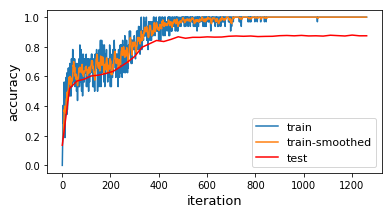

In [5]:
plt.figure(figsize = (6,3))
plt.plot(np.arange(1,len(train_accs)+1),train_accs,label='train')

train_accs_smoothing = [] 
smooth_num = 5
for i in range(len(train_accs)-smooth_num):
    begin_index = i
    end_index = i+smooth_num
    temp = train_accs[begin_index:end_index]
    train_accs_smoothing.append(np.mean(temp))
plt.plot(np.arange(smooth_num,len(train_accs)),train_accs_smoothing,label='train-smoothed')
plt.plot(np.arange(1,min(len(train_accs),(len(test_accs)-1)*30+1)+1,30),test_accs,'red',label='test')
plt.legend(fontsize=11)
plt.ylabel('accuracy',fontsize=13)
plt.xlabel('iteration',fontsize=13)
# plt.xlim(0,4000)
plt.savefig('curves.png',dpi=200,bbox_inches='tight')